In [1]:
%load_ext autoreload

%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from spikeA.Session import *
from spikeA.Spike_train_loader import Spike_train_loader
from spikeA.Cell_group import Cell_group
from spikeA.Animal_pose import Animal_pose
from spikeA.Session import Session

In [2]:
path="/adata/electro/bt8564/bt8564-20072021-0101/"
name="bt8564-20072021-0101"

Check the files

## Get a Session object and load spikes

In [3]:
ses = Kilosort_session(name=name,path=path)
ses.load_parameters_from_files()
print(ses)

<class 'spikeA.Session.Kilosort_session'>
name = bt8564-20072021-0101
path = /adata/electro/bt8564/bt8564-20072021-0101
subject = bt8564
session_dat_time = 2021-07-20 01:01:00
fileBase = /adata/electro/bt8564/bt8564-20072021-0101/bt8564-20072021-0101
file_names = {'par': '/adata/electro/bt8564/bt8564-20072021-0101/bt8564-20072021-0101.par', 'desen': '/adata/electro/bt8564/bt8564-20072021-0101/bt8564-20072021-0101.desen', 'desel': '/adata/electro/bt8564/bt8564-20072021-0101/bt8564-20072021-0101.desel', 'sampling_rate': '/adata/electro/bt8564/bt8564-20072021-0101/bt8564-20072021-0101.sampling_rate_dat', 'px_per_cm': '/adata/electro/bt8564/bt8564-20072021-0101/bt8564-20072021-0101.px_per_cm', 'params': '/adata/electro/bt8564/bt8564-20072021-0101/params.py', 'amplitudes': '/adata/electro/bt8564/bt8564-20072021-0101/amplitudes.npy', 'channel_map': '/adata/electro/bt8564/bt8564-20072021-0101/channel_map.npy', 'channel_positions': '/adata/electro/bt8564/bt8564-20072021-0101/channel_positions.

In [4]:
stl = Spike_train_loader()
stl.load_spike_train_kilosort(ses)
cg = Cell_group(stl)

## Create a pose file 

In [5]:
ap = Animal_pose(ses)
ap.pose_from_positrack_files(ses=ses, interpolation_frequency_hz = 50,extension="trk")
ap.save_pose_to_file() # save the file for next time

Interpolation step: 400.0 samples
/adata/electro/bt8564/bt8564-20072021-0101/bt8564-20072021_01.dat
/adata/electro/bt8564/bt8564-20072021-0101/bt8564-20072021_01.trk
Number of ttl pulses detected: 37834
Number of lines in positrack file: 37834
(37834, 5)
Invalid values: 2491
Valid values: 186679
Percentage of invalid values: 1.32%
shape of position data for all trials: (76185, 5)
Saving original pose to /adata/electro/bt8564/bt8564-20072021-0101/bt8564-20072021-0101.pose.npy


Plot the path of the animal to see if it was loaded correctly.

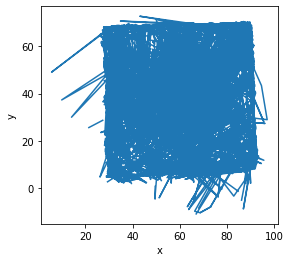

In [6]:
plt.plot(ap.pose[:,1],ap.pose[:,2])
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect('equal', adjustable='box')

Plot the head-direction of the animal and its position a short segment.

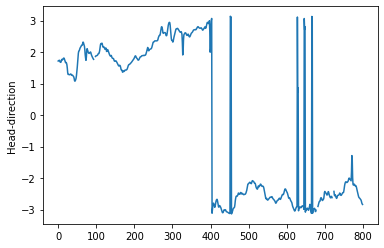

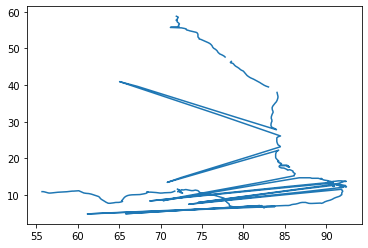

In [7]:
s=3000
e=3800
plt.plot(ap.pose[s:e,4])
plt.ylabel("Head-direction")
plt.show()
plt.plot(ap.pose[s:e,1],ap.pose[s:e,2])

Now we need to set the SpatialProperties object of each Neuron objects of the CellGroup.
Then we can get information score for each neuron from a firing rate map without smoothing.
We recalculate the maps with smoothing for display purposes.

Text(0.5, 0, 'Head direction (deg)')

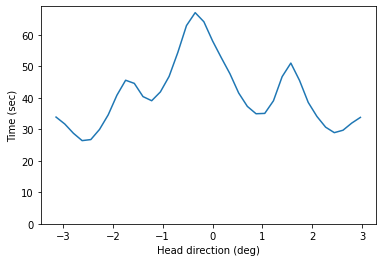

In [8]:
ap.head_direction_occupancy_histogram()
plt.plot(ap.hd_occupancy_bins[:-1],ap.hd_occupancy_histogram)
plt.ylim(0,np.max(ap.hd_occupancy_histogram)+2)
plt.ylabel("Time (sec)")
plt.xlabel("Head direction (deg)")

Loop for our neurons and do the analysis we need to know if we have spatially selective neurons or head-direction cells

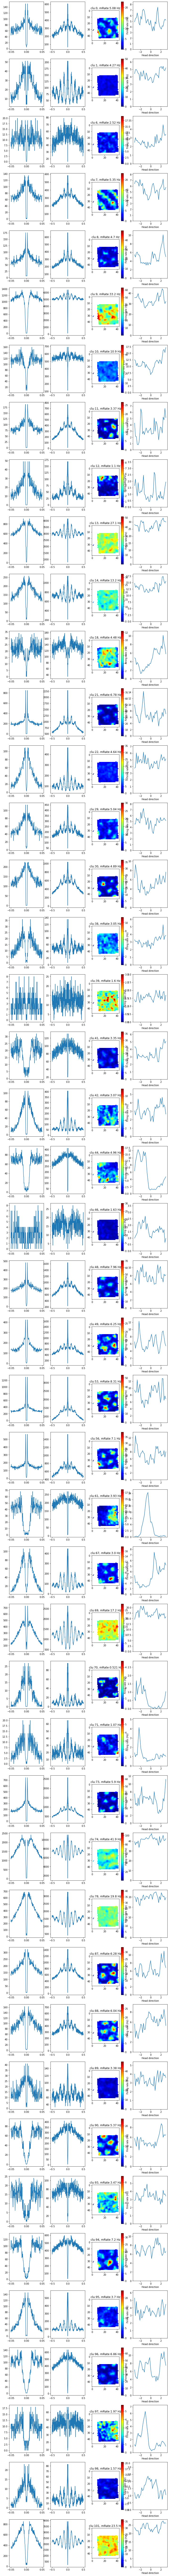

In [12]:
fig, axs = plt.subplots(len(cg.neuron_list),4,figsize=(12,200))
   
for i, n in enumerate(cg.neuron_list):
   
    n.spike_train.spike_time_autocorrelation(bin_size_sec=0.0005,min_sec=-0.05, max_sec=0.05)
    timestamp = n.spike_train.mid_point_from_edges(n.spike_train.st_autocorrelation_histogram[1])
    axs[i,0].plot(timestamp, n.spike_train.st_autocorrelation_histogram[0])
    
    n.spike_train.spike_time_autocorrelation(bin_size_sec=0.0025,min_sec=-0.5, max_sec=0.5)
    timestamp = n.spike_train.mid_point_from_edges(n.spike_train.st_autocorrelation_histogram[1])
    axs[i,1].plot(timestamp, n.spike_train.st_autocorrelation_histogram[0])
    n.spike_train.unset_intervals()
    ap.unset_intervals()
    n.spike_train.set_intervals(ses.trial_intervals.inter)
    ap.set_intervals(ses.trial_intervals.inter)
    n.set_spatial_properties(ap)
    n.spatial_properties.firing_rate_map_2d(cm_per_bin =2, smoothing_sigma_cm = 2, smoothing=True)
    im = axs[i,2].imshow(n.spatial_properties.firing_rate_map,cmap='jet')
    axs[i,2].set_title("clu:{}, mRate:{:.3} Hz".format(n.name,n.spike_train.mean_firing_rate()))
    fig.colorbar(im,ax=axs[i,2])
    
    n.spatial_properties.firing_rate_head_direction_histogram(smoothing=False)
    axs[i,3].plot(n.spatial_properties.firing_rate_head_direction_histo_edges[:-1],n.spatial_properties.firing_rate_head_direction_histo)
    axs[i,3].set_xlabel("Head direction")
    axs[i,3].set_ylabel("Firing rate (Hz)")
    axs[i,3].set_ylim(0,np.max(n.spatial_properties.firing_rate_head_direction_histo)+1)
plt.show()
#plt.savefig('/home/moritz/Downloads/TYY5630-100721-0101.pdf')